In [1]:
%env MUJOCO_GL=egl

import mujoco
import cv2
import time
import numpy as np
import torch
from scipy.spatial.transform import Rotation

import os
import mediapy

import discoverse
from discoverse.envs import make_env
from discoverse import DISCOVERSE_ASSETS_DIR
from discoverse.robots_env.airbot_play_base import AirbotPlayCfg
from discoverse.utils import get_body_tmat
from discoverse.task_base import AirbotPlayTaskBase

class SimNode(AirbotPlayTaskBase):
    def __init__(self, config: AirbotPlayCfg):
        super().__init__(config)
        self.camera_0_pose = (self.mj_model.camera("eye_side").pos.copy(), self.mj_model.camera("eye_side").quat.copy())

    def domain_randomization(self):
        # 随机 杯子位置
        self.object_pose("coffeecup_white")[:2] += 2.*(np.random.random(2) - 0.5) * np.array([0.2, 0.06])

        # 随机 盘子位置
        self.object_pose("plate_white")[:2] += 2.*(np.random.random(2) - 0.5) * np.array([0.0625, 0.02])

        # 随机 桌面纹理
        # self.random_table_texture()

        # 随机物体材质
        self.random_material("coffeecup_texture")
        self.random_material("plate_white_texture")

        # 随机 灯光
        # self.random_light()

    def check_success(self):
        tmat_cup = get_body_tmat(self.mj_data, "coffeecup_white")
        tmat_plate = get_body_tmat(self.mj_data, "plate_white")
        return (abs(tmat_cup[2, 2]) > 0.99) and np.hypot(tmat_plate[0, 3] - tmat_cup[0, 3], tmat_plate[1, 3] - tmat_cup[1, 3]) < 0.02


env: MUJOCO_GL=egl


body airbot_play_pose
mjcf found: /home/yufei/simulator/DISCOVERSE/models/mjcf/tmp/airbot_play_place_coffeecup.xml
mjcf found: /home/yufei/simulator/DISCOVERSE/models/mjcf/tmp/airbot_play_place_coffeecup.xml
screeninfo error: No enumerators available, using default screen size: 1920x1080
Using rendering backend: gsplat
screeninfo error: No enumerators available, using default screen size: 1920x1080
Using rendering backend: gsplat
dict_keys(['time', 'jq', 'jv', 'jf', 'ep', 'eq', 'img', 'depth'])
dict_keys([0, 1])
0: (480, 640, 3) dtype=uint8
1: (480, 640, 3) dtype=uint8
dict_keys(['time', 'jq', 'jv', 'jf', 'ep', 'eq', 'img', 'depth'])
dict_keys([0, 1])
0: (480, 640, 3) dtype=uint8
1: (480, 640, 3) dtype=uint8


""

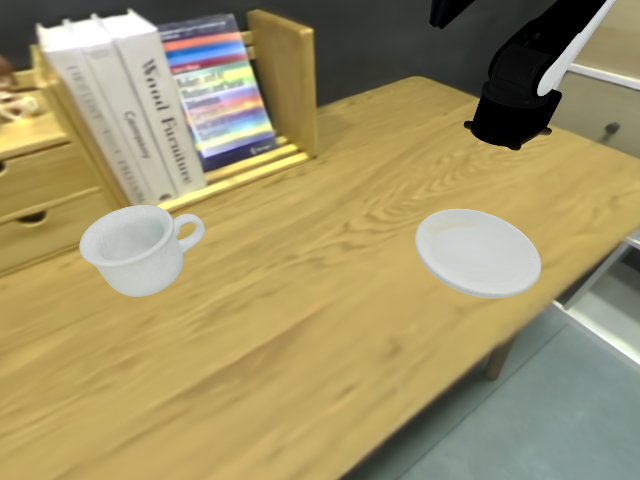

Rendered image shape: (480, 640, 3) dtype=uint8


""

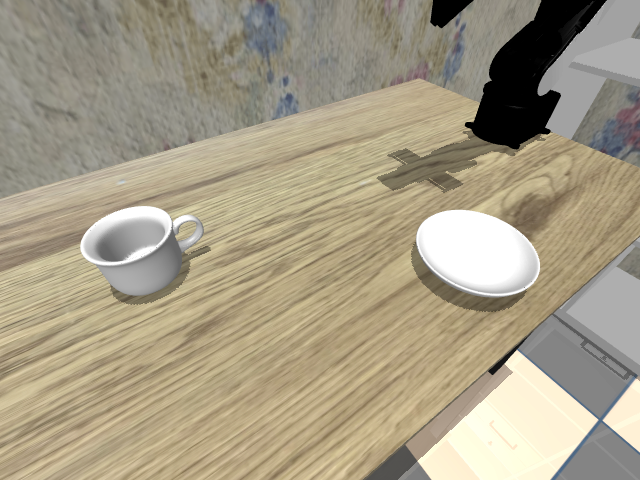

In [2]:
cfg = AirbotPlayCfg()
cfg.gs_model_dict["background"]      = "scene/lab3/point_cloud.ply"
cfg.gs_model_dict["drawer_1"]        = "hinge/drawer_1.ply"
cfg.gs_model_dict["drawer_2"]        = "hinge/drawer_2.ply"
cfg.gs_model_dict["plate_white"]     = "object/plate_white.ply"
cfg.gs_model_dict["coffeecup_white"] = "object/teacup.ply"
cfg.init_qpos[:] = [-0.055, -0.547, 0.905, 1.599, -1.398, -1.599,  0.0]

robot_name = "airbot_play"
task_name = "place_coffeecup"
cfg.mjcf_file_path = f"mjcf/tmp/{robot_name}_{task_name}.xml"
env = make_env(robot_name, task_name)
env.export_xml(os.path.join(DISCOVERSE_ASSETS_DIR, cfg.mjcf_file_path))

cfg.obj_list     = ["drawer_1", "drawer_2", "plate_white", "coffeecup_white"]
cfg.timestep     = 1/240
cfg.decimation   = 4
cfg.sync         = True
cfg.headless     = True
cfg.render_set   = {
    "fps"    : 20,
    "width"  : 640, #80, # 192, # 128, # 640, #1920
    "height" : 480, #80, # 108, # 128, # 480, #1080
}
cfg.obs_rgb_cam_id = [0, 1]
cfg.obs_depth_cam_id = [0, 1]
cfg.save_mjb_and_task_config = True
cfg.use_gaussian_renderer = True

sim_node = SimNode(cfg)
renderer = mujoco.Renderer(sim_node.mj_model, cfg.render_set["height"], cfg.render_set["width"])

obs = sim_node.reset()
print(obs.keys())
print(obs["img"].keys())

for k in obs["img"]:
    print(f"{k}: {obs['img'][k].shape} dtype={obs['img'][k].dtype}")
mediapy.show_image(obs["img"][0])
# mediapy.show_image(cv2.resize(obs["img"][0], (720, 720), interpolation=cv2.INTER_CUBIC))

# for k in obs["depth"]:
#     print(f"{k}: {obs['depth'][k].shape} dtype={obs['depth'][k].dtype}")
# mediapy.show_image(obs["depth"][0])

renderer.update_scene(sim_node.mj_data, 0)
img = renderer.render()
print(f"Rendered image shape: {img.shape} dtype={img.dtype}")
mediapy.show_image(img)

In [ ]:
print(sim_node.mj_model.ncam)
print(sim_node.mj_data.cam_xpos.shape)
print(sim_node.mj_data.cam_xmat.shape)

print(sim_node.mj_model.nbody)
print(sim_node.mj_data.xpos.shape)
print(sim_node.mj_data.xmat.shape)

body_ids = []
for i in range(sim_node.mj_model.nbody):
    if sim_node.mj_model.body(i).name in cfg.obj_list + cfg.rb_link_list:
        body_ids.append(i)
body_ids = np.array(body_ids, np.int64)

print("Tracked body ids:", body_ids)
print(sim_node.mj_data.xpos[body_ids].shape, sim_node.mj_data.xmat[body_ids].shape)

In [ ]:
# 性能测试
print("Starting benchmark...")
start_time = time.time()
steps = 100

for _ in range(steps):
    sim_node.step(np.zeros(7))
    # old version FPS: 346.47

end_time = time.time()
fps = steps / (end_time - start_time)
print(f"Update FPS: {fps:.2f}")